# Лабораторна робота №6

## Основне завдання

Для даних по титаніку titanic.csv побудувати модель, в якій можна визначити, чи виживе пасажир, заповнивши решту параметрів.
Використати декілька методів. Порівняти результати. 

## Хід роботи

### Попередня обробка даних

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
sns.set_palette('crest')
custom_cmap = sns.color_palette('crest', as_cmap=True)

Зчитуємо дані до датафрейму df:

In [3]:
df = pd.read_csv('resources/titanic.csv')

Виводимо перші 5 записів датафрейму df:

In [4]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Виводимо інформацію про структуру датафрейму df:

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Видаляємо інформацію про квитки, id пасажирів та імена пасажирів, оскільки їх не вдасться застосувати при побудові моделей для прогнозування:

In [6]:
df = df.drop(columns=['PassengerId', 'Ticket', 'Name'])

Змінюємо тип атрибуту Pclass (клас квитка) на str. У такий спосіб ми зазначаємо, що даний атрибут є категоріальним. 

In [7]:
df['Pclass'] = df['Pclass'].astype(str)

Будуємо діаграму для відображення пропущених значень:

In [8]:
def display_missing_values_plot(df):
    plt.title('Missing Values')
    ax = sns.heatmap(df.isna().sum().to_frame(), annot=True, fmt='d', 
                     cmap=custom_cmap, linewidths=0.5, cbar=False)
    ax.set_xlabel('Number of Missing Values')
    ax.set(xticklabels=[])
    ax.tick_params(bottom=False)
    plt.show()

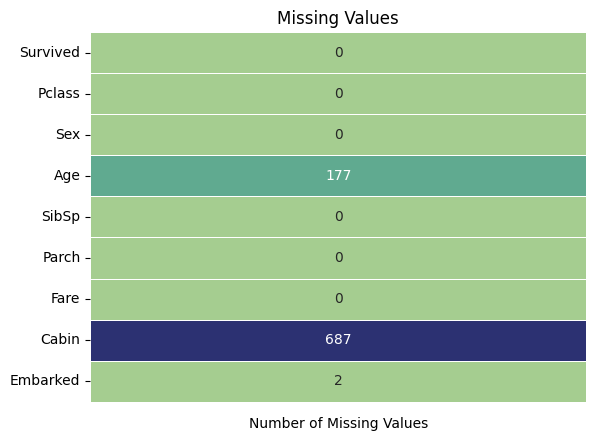

In [9]:
display_missing_values_plot(df)

Бачимо, що кількість пропущених значень атрибута Cabin є дуже великою (687 пропущених при 891-ому записі в датафреймі), тому видаляємо даний атрибут з датафрейму:

In [10]:
df = df.drop(columns=['Cabin'])

Пропуски в Age Embarked заповнюємо модами:

In [11]:
df['Age'].fillna(df['Age'].mode()[0], inplace=True)
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)

Переконуємося, що пропущених значень у датафреймі не залишилося:

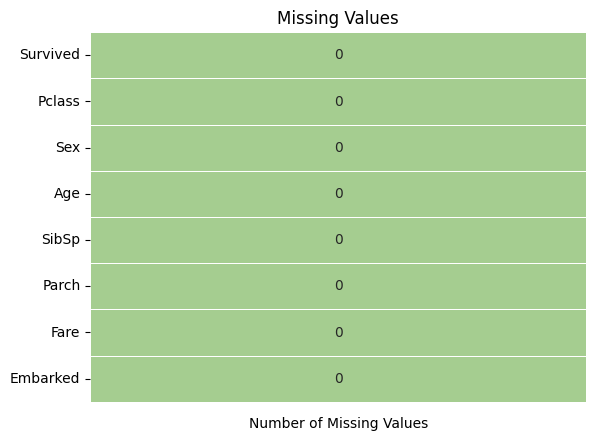

In [12]:
display_missing_values_plot(df)

Кодуємо категоріальні атрибути датафрейму за допомогою TargetEncoder:

In [13]:
from category_encoders import TargetEncoder

In [14]:
encoder = TargetEncoder()
df['Sex'] = encoder.fit_transform(df['Sex'], df['Survived'])
df['Pclass'] = encoder.fit_transform(df['Pclass'], df['Survived'])
df['Embarked'] = encoder.fit_transform(df['Embarked'], df['Survived'])

Ділимо дані на навчальну і тестову вибірки:

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
X = df.drop(['Survived'], axis=1)
y = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Бачимо, що тренувальні дані є не збалансованими за кількістю тих, хто вижив / загинув:

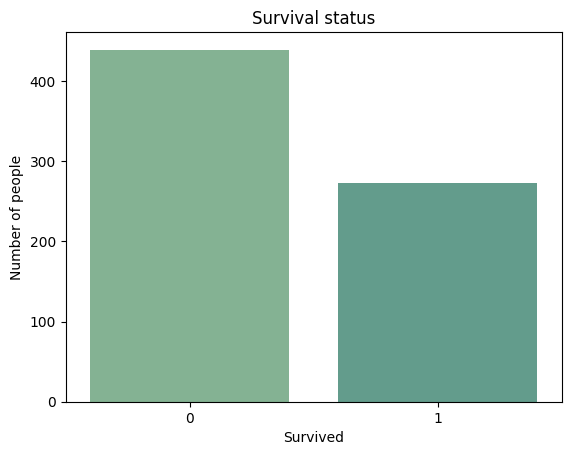

In [17]:
ax = sns.countplot(x=y_train)
ax.set_ylabel('Number of people')
plt.title('Survival status')
plt.show()

Використовуємо SMOTE() для балансування тренувальної вибірки:

In [18]:
from imblearn.over_sampling import SMOTE

In [19]:
resampler = SMOTE(sampling_strategy = 1)
X_train_res, y_train_res = resampler.fit_resample(X_train, y_train)

Пересвідчуємося, що тренувальні дані тепер збалансовані:

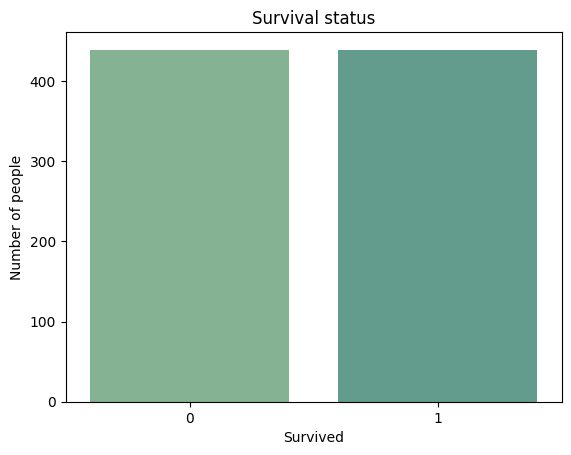

In [20]:
ax = sns.countplot(x=y_train_res)
ax.set_ylabel('Number of people')
plt.title('Survival status')
plt.show()

### Побудова і тестування моделей

In [21]:
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

Для роботи були обрані такі методи класифікації: K-Nearest Neighbors, Decision Tree, AdaBoost, Support Vector Machine, Gradient Boosting, Random Forest.

In [22]:
classifiers = [('K-Nearest Neighbors', KNeighborsClassifier()),
               ('Decision Tree', DecisionTreeClassifier()),
               ('AdaBoost', AdaBoostClassifier()),
               ('Support Vector Machine', SVC()),
               ('Gradient Boosting', GradientBoostingClassifier()), 
               ('Random Forest', RandomForestClassifier())]

Будуємо і тестуємо дані моделі за допомогою функції test_classifiers. Тестування відбуватиметься з використанням тестової вибірки. Для наочності будуть побудовані діаграми типу confusion matrix та classification report-и (містять оцінки recall, precision, f1 та accuracy) для кожної моделі.

In [23]:
def display_confusion_matrix(classifier_name, y_test, y_pred):
    plt.title(classifier_name)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='g', cmap=custom_cmap, cbar=False,
        yticklabels=['Actual non-survival', 'Actual survival'], 
                xticklabels=['Predicted non-survival', 'Predicted survival'])
    plt.show()

In [24]:
def test_classifiers(X_train, y_train, X_test, y_test, classifiers):
    scaler = StandardScaler()
    scaled_X_train = scaler.fit_transform(X_train)
    scaled_X_test = scaler.transform(X_test)
    
    for classifier_name, classifier in classifiers:
        model = classifier.fit(scaled_X_train, y_train)
        y_pred = model.predict(scaled_X_test)
        display_confusion_matrix(classifier_name, y_test, y_pred)
        print(classification_report(y_test, y_pred))

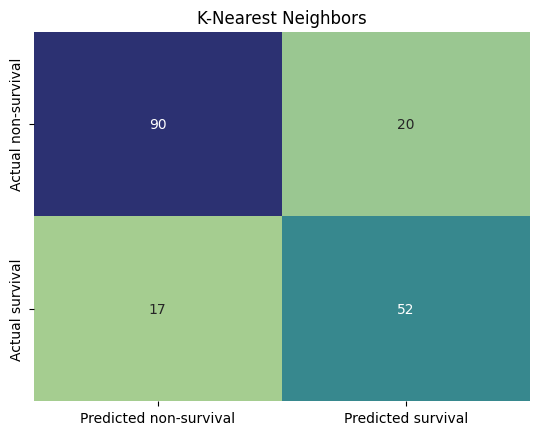

              precision    recall  f1-score   support

           0       0.84      0.82      0.83       110
           1       0.72      0.75      0.74        69

    accuracy                           0.79       179
   macro avg       0.78      0.79      0.78       179
weighted avg       0.80      0.79      0.79       179



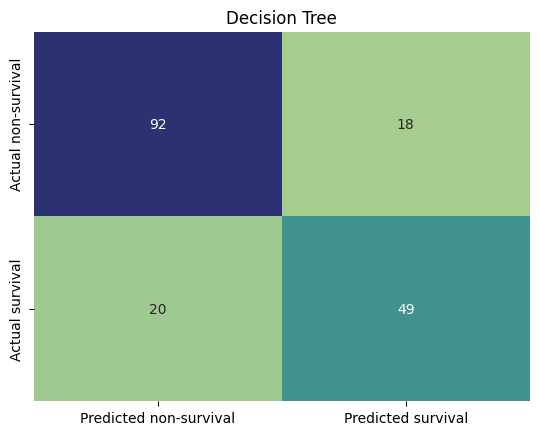

              precision    recall  f1-score   support

           0       0.82      0.84      0.83       110
           1       0.73      0.71      0.72        69

    accuracy                           0.79       179
   macro avg       0.78      0.77      0.77       179
weighted avg       0.79      0.79      0.79       179



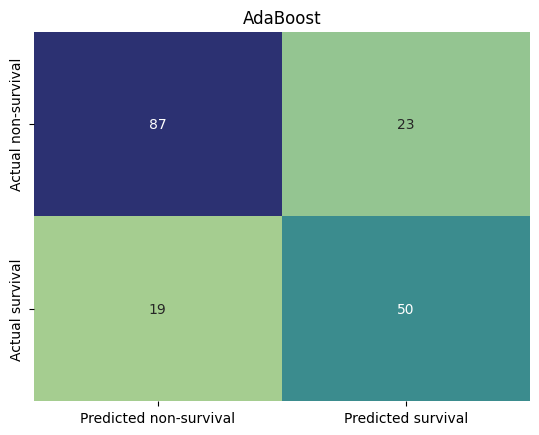

              precision    recall  f1-score   support

           0       0.82      0.79      0.81       110
           1       0.68      0.72      0.70        69

    accuracy                           0.77       179
   macro avg       0.75      0.76      0.75       179
weighted avg       0.77      0.77      0.77       179



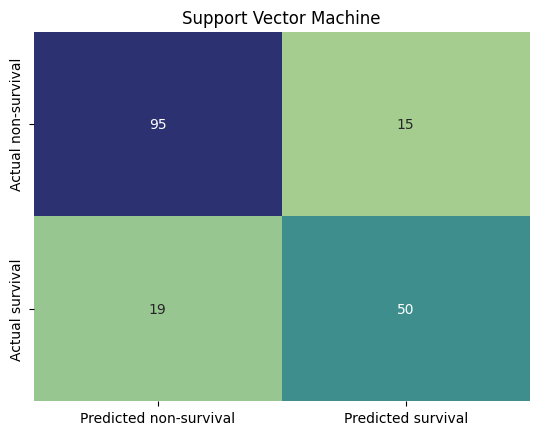

              precision    recall  f1-score   support

           0       0.83      0.86      0.85       110
           1       0.77      0.72      0.75        69

    accuracy                           0.81       179
   macro avg       0.80      0.79      0.80       179
weighted avg       0.81      0.81      0.81       179



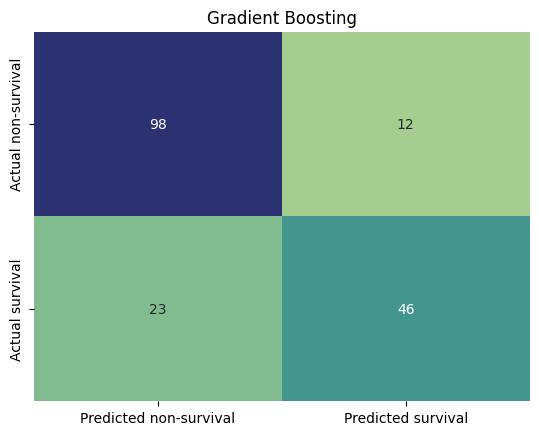

              precision    recall  f1-score   support

           0       0.81      0.89      0.85       110
           1       0.79      0.67      0.72        69

    accuracy                           0.80       179
   macro avg       0.80      0.78      0.79       179
weighted avg       0.80      0.80      0.80       179



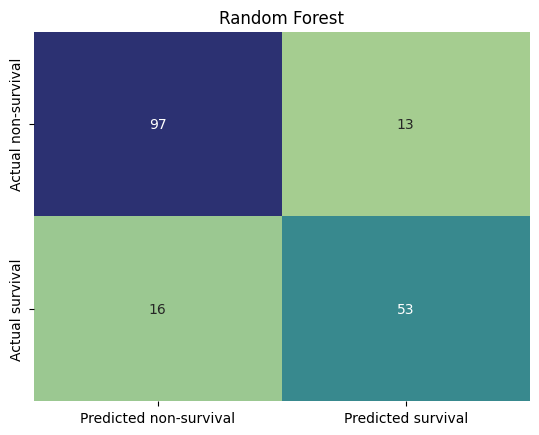

              precision    recall  f1-score   support

           0       0.86      0.88      0.87       110
           1       0.80      0.77      0.79        69

    accuracy                           0.84       179
   macro avg       0.83      0.82      0.83       179
weighted avg       0.84      0.84      0.84       179



In [25]:
test_classifiers(X_train_res, y_train_res, X_test, y_test, classifiers)

Бачимо, оцінки f1 та accuracy є досить близькими для всіх моделей. Скористаємося крос-валідацією для визначення кращої моделі серед обраних:

In [26]:
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from imblearn.pipeline import Pipeline

In [27]:
def cross_validate_classifiers(X, y, classifiers, scorings=['accuracy']):
    for classifier_name, classifier in classifiers:
        pipe = Pipeline(steps = [('resampler', SMOTE()), ('scaler', StandardScaler()), ('clf', classifier)])

        print(f'Classifier: {classifier_name}')
        for scoring in scorings:
            print(f'\tcv score ({scoring}):  \t', '{0:.2%}'
                  .format(cross_val_score(pipe, X, y, cv=10, scoring=scoring, n_jobs=-1).mean()))

In [28]:
cross_validate_classifiers(X, y, classifiers, ['f1', 'accuracy'])

Classifier: K-Nearest Neighbors
	cv score (f1):  	 74.76%
	cv score (accuracy):  	 79.25%
Classifier: Decision Tree
	cv score (f1):  	 72.65%
	cv score (accuracy):  	 79.35%
Classifier: AdaBoost
	cv score (f1):  	 75.37%
	cv score (accuracy):  	 80.93%
Classifier: Support Vector Machine
	cv score (f1):  	 75.27%
	cv score (accuracy):  	 82.16%
Classifier: Gradient Boosting
	cv score (f1):  	 76.38%
	cv score (accuracy):  	 83.06%
Classifier: Random Forest
	cv score (f1):  	 74.59%
	cv score (accuracy):  	 80.81%


Отже, найкращою моделлю виявилася та, що використовувала метод Gradient Boosting.